In [1]:
import os.path
import tensorflow as tf
import helper
# import project_tests as tests
import numpy as np

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
hyperparams = {}
hyperparams_set = []

In [3]:
graph = tf.get_default_graph()
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    model = tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)

    graph = tf.get_default_graph()

    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return image_input, keep_prob, layer3, layer4, layer7

In [4]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    kernel_regularizer = tf.contrib.layers.l2_regularizer(1e-3)
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()

    pool3_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)

    pool4_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)

    conv7_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)

    # make prediction of segmentation
    deconv7 = tf.layers.conv2d_transpose(conv7_1x1, num_classes, kernel_size=4, strides=2, padding='same',
                                         kernel_initializer=kernel_initializer, 
                                         kernel_regularizer=kernel_regularizer)

    fuse1 = tf.add(deconv7, pool4_1x1)
    deconv_fuse1 = tf.layers.conv2d_transpose(fuse1, num_classes, kernel_size=4, strides=2, padding='same',
                                              kernel_initializer=kernel_initializer,
                                              kernel_regularizer=kernel_regularizer)

    fuse2 = tf.add(deconv_fuse1, pool3_1x1)

    out = tf.layers.conv2d_transpose(fuse2, num_classes, kernel_size=16, strides=8, padding='same',
                                     kernel_initializer=kernel_initializer, 
                                     kernel_regularizer=kernel_regularizer)

    return out

In [5]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))
#     train_op = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(cross_entropy_loss)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_loss)

    return logits, train_op, cross_entropy_loss

In [6]:
# HYPERPARAMETERS
for i in range(20):
    LEARNING_RATE = np.random.uniform(1e-5, 5*1e-4)
    BATCH_SIZE = np.random.randint(2, 6)
    KEEP_PROB = np.random.uniform(0.2, 0.7)
    print("BATCH_SIZE: ", BATCH_SIZE)
    print("LEARNING_RATE: ", LEARNING_RATE)
    print("KEEP_PROB", KEEP_PROB)

    def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
                 correct_label, keep_prob, learning_rate):
        """
        Train neural network and print out the loss during training.
        :param sess: TF Session
        :param epochs: Number of epochs
        :param batch_size: Batch size
        :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
        :param train_op: TF Operation to train the neural network
        :param cross_entropy_loss: TF Tensor for the amount of loss
        :param input_image: TF Placeholder for input images
        :param correct_label: TF Placeholder for label images
        :param keep_prob: TF Placeholder for dropout keep probability
        :param learning_rate: TF Placeholder for learning rate
        """
        # TODO: Implement function
        sess.run(tf.global_variables_initializer())
        loss_per_epoch = []
        for epoch in range(epochs):
            losses, i = [], 0
            for images, labels in get_batches_fn(batch_size):
                i += 1
                feed_dict = {input_image: images, 
                             correct_label: labels, 
                             keep_prob: KEEP_PROB, 
                             learning_rate: LEARNING_RATE}
                _, loss = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
                losses.append(loss)

            training_loss = sum(losses) / len(losses)
            loss_per_epoch.append(training_loss)
            if (epoch+1) % 5 == 0:
                print(" [-] epoch: %d/%d, loss: %.5f" % (epoch+1, epochs, training_loss))
        return loss_per_epoch

    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.95
    config.gpu_options.allow_growth = True
    tf.reset_default_graph()
    with tf.Session(config=config) as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # TODO: Build NN using load_vgg, layers, and optimize function
        image_input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        out = layers(layer3, layer4, layer7, num_classes)

        correct_label = tf.placeholder(tf.int32)
        learning_rate = tf.placeholder(tf.float32)
        logits, train_op, cross_entropy_loss = optimize(out, correct_label, learning_rate, num_classes)

        # TODO: Train NN using the train_nn function
        epochs = 20
        batch_size = BATCH_SIZE
        loss_per_epoch = train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input, correct_label, keep_prob, learning_rate)

        # record results
        hyperparams = {'learning_rate': LEARNING_RATE, 
                       'BATCH_SIZE': BATCH_SIZE, 
                       'KEEP_PROB': KEEP_PROB, 
                       'LOSS_PER_EPOCH': loss_per_epoch}

        hyperparams_set.append(hyperparams)

BATCH_SIZE:  4
LEARNING_RATE:  0.00031703677781598635
KEEP_PROB 0.2790067196790674
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
 [-] epoch: 5/20, loss: 0.64272
 [-] epoch: 10/20, loss: 0.45527
 [-] epoch: 15/20, loss: 0.16347
 [-] epoch: 20/20, loss: 0.12491
BATCH_SIZE:  3
LEARNING_RATE:  0.0004927942759388852
KEEP_PROB 0.3229376291734368
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
 [-] epoch: 5/20, loss: 0.27613
 [-] epoch: 10/20, loss: 0.17152
 [-] epoch: 15/20, loss: 0.12661
 [-] epoch: 20/20, loss: 0.08740
BATCH_SIZE:  5
LEARNING_RATE:  0.00028620438423460754
KEEP_PROB 0.5250035005865881
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
 [-] epoch: 5/20, loss: 0.41323
 [-] epoch: 10/20, loss: 0.19100
 [-] epoch: 15/20, loss: 0.14225
 [-] epoch: 20/20, loss: 0.11034
BATCH_SIZE:  4
LEARNING_RATE:  0.00047425824916267663
KEEP_PROB 0.345123508179212
INFO:tensorflow:Restoring parameters from b'./dat

Text(0.5,1,'Best: lr=0.00024, bs=2, kp=0.50, loss=0.0515')

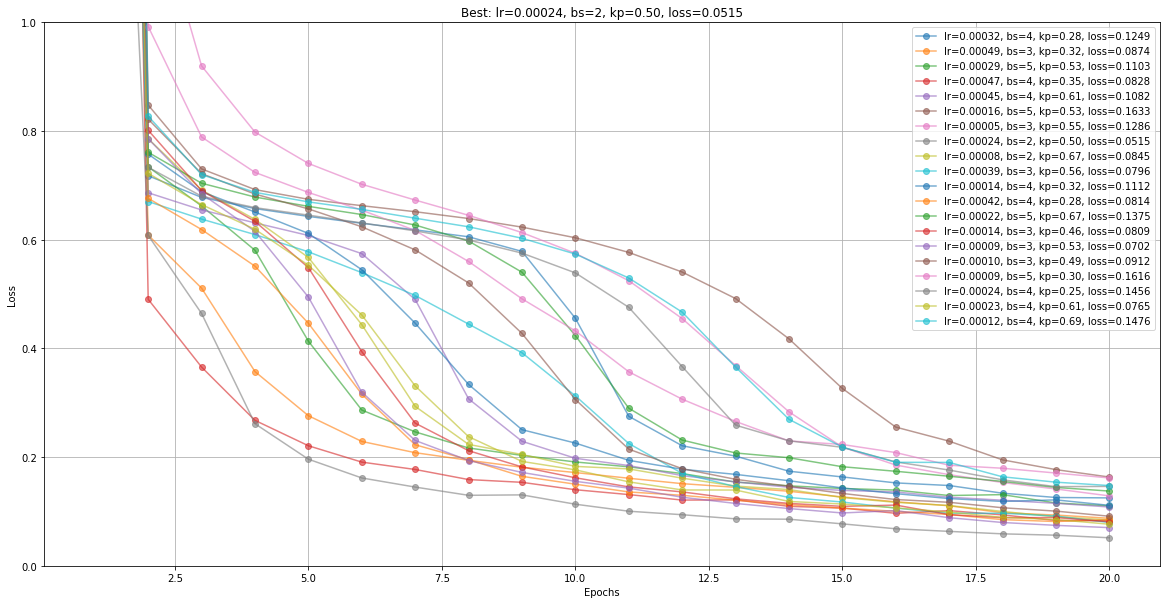

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
lowest_loss = 9.

plt.figure(figsize=(20,10))
for i in range(len(hyperparams_set)):
    hyperparams = hyperparams_set[i]
    LEARNING_RATE = hyperparams['learning_rate']
    BATCH_SIZE = hyperparams['BATCH_SIZE']
    KEEP_PROB  = hyperparams['KEEP_PROB']
    loss_per_epoch = hyperparams['LOSS_PER_EPOCH']
    
    label_name = 'lr=%.5f, bs=%d, kp=%.2f, loss=%.4f' % (LEARNING_RATE, BATCH_SIZE, KEEP_PROB, np.min(loss_per_epoch))
    
    _epoch = np.linspace(1, len(loss_per_epoch), len(loss_per_epoch))
    plt.plot(_epoch, loss_per_epoch, 'o-', alpha=0.6, label=label_name)
    if np.min(loss_per_epoch) < lowest_loss:
        lowest_loss = np.min(loss_per_epoch)
        best_name = label_name
        best_hyperparams = hyperparams
        
    
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epochs')
title_str = 'Best: '+ best_name
plt.title(title_str)

In [8]:
# TODO: Save inference data using helper.save_inference_samples
#  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
# helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, image_input)

# OPTIONAL: Apply the trained model to a video